# Phase 4 Project

## Business Objective

To help Acme Online, an online electronics store, analyze customer tweets from their Twitter page about Apple and Google products. The result of this analysis will be used to find out which company's product has more favourable reviews and the reasons behind it - this will help Acme Online adjust their inventory accordingly.

## Methodology

1. Analyze tweets to check which product category is the most popular among customers.
2. Analyze tweets to check what customers like/dislike about each category.
2. We will attempt to build a model using NLP that helps classify tweets based on Apple or Google products. We will use the f1-score for model evaluations since reducing FP's and FN's is more valuable in this case.

# Dataset

Dataset sourced from CrowdFlower via data.world: https://data.world/crowdflower/brands-and-product-emotions

# Analysis

In [1]:
#import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np
from nltk import word_tokenize
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import warnings
warnings.filterwarnings('ignore')

Importing the dataset:

In [2]:
df= pd.read_csv('tweets.csv',encoding='unicode escape',)
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Pre-processing

To save ourselves from lot's of keystrokes, let's rename the columns:

In [3]:
#renaming the columns to make it less cumbersome
df.rename(columns={'emotion_in_tweet_is_directed_at':'product_service',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'},inplace=True)
df.head()

,tweet_text,product_service,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#getting some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product_service  3291 non-null   object
 2   emotion          9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


There are no numeric values in our df which is what we'd expect given that we're analyzing tweets.

In [5]:
#checking for null values
df.isna().sum()

tweet_text            1
product_service    5802
emotion               0
dtype: int64

From the above,we can see that the `product_service` column has a large number of missing values; more than 50%. Let's leave it for now and remove the one empty row in `tweet_text`

In [6]:
#removing the null value in the tweet_text column
df = df[df['tweet_text'].notnull()]

Let's take a look at the `product_service` column to see the different kinds of products that are involved:

In [7]:
#examining the product_service column
df['product_service'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_service, dtype: int64

Let's group some of the categories to facilitate easier analysis:

In [8]:
#let's group product/services that resemble each other for both brands. This will make for easier analysis

df['product_service'].replace('Other Google product or service','Google',inplace=True)
df['product_service'].replace('Other Apple product or service','Apple',inplace=True)
df['product_service'].replace('Android App','Android',inplace=True)
df['product_service'].fillna('Not Applicable',inplace=True)

#checking
df['product_service'].value_counts()

Not Applicable        5801
iPad                   946
Google                 723
Apple                  696
iPad or iPhone App     470
iPhone                 297
Android                159
Name: product_service, dtype: int64

Let's apply some of the common pre-processing steps when it comes to working with text data:

1. Remove capitalization
2. Remove punctuations and special characters
3. Tokenizing

In [9]:
# Removing capiltalization
df['tweet_text'] = df['tweet_text'].str.lower()

#removing punctuations using the default pattern in sklearn and tokenizing
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

#applying the tokenizer to the df and creating a new column
df['text_token'] = df['tweet_text'].apply(tokenizer.tokenize)
df.head(10)

,tweet_text,product_service,emotion,text_token
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."
5,@teachntech00 new ipad apps for #speechtherapy...,Not Applicable,No emotion toward brand or product,"[teachntech00, new, ipad, apps, for, speechthe..."
7,"#sxsw is just starting, #ctia is around the co...",Android,Positive emotion,"[sxsw, is, just, starting, ctia, is, around, t..."
8,beautifully smart and simple idea rt @madebyma...,iPad or iPhone App,Positive emotion,"[beautifully, smart, and, simple, idea, rt, ma..."
9,counting down the days to #sxsw plus strong ca...,Apple,Positive emotion,"[counting, down, the, days, to, sxsw, plus, st..."
10,excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,"[excited, to, meet, the, samsungmobileus, at, ..."


# What words are tweeted the most?

By answering this question, we can understand what customers are tweeting about. We can visualize this using a feature called **_WordCloud_.**

## Wordcloud

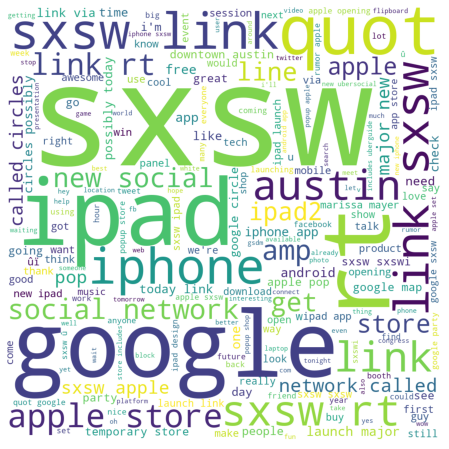

In [10]:
#importing the stopwords list to pass onto the WC generator
stopwords_list = stopwords.words('english')
stopwords_list.append('mention')

#droppping null values
df.dropna(inplace=True)

#instantiate
wc = WordCloud(background_color='white',
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )

#for the wordcloud, we have to join all the text data into a single string 
text = " ".join(df['tweet_text'])

#generate the WC
wc.generate(text)

#plot the WC
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(wc)
plt.show()

## FreqDist

Let's use `nltk's FreqDist` class to get some numbers to gives us more clarity:

## Removing _stopwords_

Words like `a,as,the,for,that etc.` are used to make the sentence grammatically correct but give very little information about the contents of the text itself. Since they are most likely to occur a lot more than nouns and adjectives, they also distort our analysis and are hence best removed from the corpus for analysis.

In [11]:
#defining a function to remove stopwords
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

#applying the function to the text_token column
df['text_token'] = df['text_token'].apply(remove_stopwords)

In [12]:
#defining a function to plot the top_25 most occuring words

def plot_freq_dist(words):
    freq_dist = FreqDist(df[words].explode())
    # listing out the top 25 most occuring words and ther respective counts
    top_25 = list(zip(*freq_dist.most_common(25)))

    #creating a plot of the top_25 words
    fig,ax=plt.subplots(figsize=(10,10))
    ax.bar(top_25[0],top_25[1])
    ax.set_title('Top 25 most occurring words')
    ax.tick_params(axis='x', rotation=90)

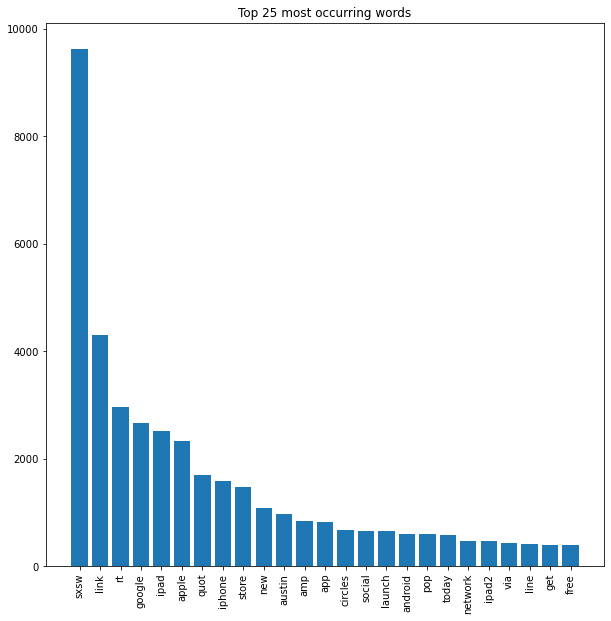

In [13]:
#plotting the freq_dist
plot_freq_dist('text_token')

We can see from the above that the words `SXSW,Google,iPad` are some of the most tweeted words. A google search of `SXSW` reveals it to be arts and music festival held in Austin,TX. Hence, we can reasonably conclude that tweets collected for the analysis was from the city of Austin,TX and also coincided when the festival was running.

# Analyzing emotions for each product_service

This is to answer the first question : What are the emotional repsonses for each product_service category listed in the data? For eg: for the category 'Apple' how many positive,negative and neutral responses are there?

By comparing the responses for each category, we can gage customer sentiment

**_Pivot Tables_** can help better organize the data for the analysis

In [14]:
#creating a pivot table to organize the data

df_pivot = df.pivot_table(index='product_service',aggfunc='count',columns='emotion')
df_pivot

text_token                   \
emotion            I can't tell Negative emotion   
product_service                                    
Android                     NaN             16.0   
Apple                       2.0             97.0   
Google                      2.0            115.0   
Not Applicable            147.0             51.0   
iPad                        4.0            125.0   
iPad or iPhone App          NaN             63.0   
iPhone                      1.0            103.0   

                                                                        \
emotion            No emotion toward brand or product Positive emotion   
product_service                                                          
Android                                           2.0            141.0   
Apple                                            22.0            575.0   
Google                                           24.0            582.0   
Not Applicable                                 5297.0            306.0   
iPad                                             24.0            793.0   
iPad or iPhone App                               10.0            397.0   
iPhone                                            9.0            184.0   

                     tweet_text                   \
emotion            I can't tell Negative emotion   
product_service                                    
Android                     NaN             16.0   
Apple                       2.0             97.0   
Google                      2.0            115.0   
Not Applicable            147.0             51.0   
iPad                        4.0            125.0   
iPad or iPhone App          NaN             63.0   
iPhone                      1.0            103.0   

                                                                        
emotion            No emotion toward brand or product Positive emotion  
product_service                                                         
Android                                           2.0            141.0  
Apple                                            22.0            575.0  
Google                                           24.0            582.0  
Not Applicable                                 5297.0            306.0  
iPad                                             24.0            793.0  
iPad or iPhone App                               10.0            397.0  
iPhone                                            9.0            184.0

In [15]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, Android to iPhone
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   (text_token, I can't tell)                        5 non-null      float64
 1   (text_token, Negative emotion)                    7 non-null      float64
 2   (text_token, No emotion toward brand or product)  7 non-null      float64
 3   (text_token, Positive emotion)                    7 non-null      float64
 4   (tweet_text, I can't tell)                        5 non-null      float64
 5   (tweet_text, Negative emotion)                    7 non-null      float64
 6   (tweet_text, No emotion toward brand or product)  7 non-null      float64
 7   (tweet_text, Positive emotion)                    7 non-null      float64
dtypes: float64(8)
memory usage: 504.0+ bytes


Since the `text_column` is not relevant right now, let's remove it:

In [16]:
#dropping the columns
df_pivot.drop(df_pivot.columns[[0,1,2,3]],axis=1,inplace=True)

Renaming the columns for better understanding:

In [17]:
#renaming the columns
df_pivot.columns = ["I can't tell",'Negative emotion','No emotion toward brand or product', 'Positive emotion']
df_pivot

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
product_service,,,,
Android,NaN,16.0,2.0,141.0
Apple,2.0,97.0,22.0,575.0
Google,2.0,115.0,24.0,582.0
Not Applicable,147.0,51.0,5297.0,306.0
iPad,4.0,125.0,24.0,793.0
iPad or iPhone App,NaN,63.0,10.0,397.0
iPhone,1.0,103.0,9.0,184.0


In [18]:
#dropping 'Not Applicable' since it is not relevant here
df_pivot.drop('Not Applicable',axis=0,inplace=True)

#rearranging the columns for better visualization
df_pivot=df_pivot[['Positive emotion','Negative emotion', 'No emotion toward brand or product', "I can't tell"]]

#sorting the values for better visuzalization
df_pivot.sort_values('Positive emotion',ascending=False,inplace=True)

df_pivot

,Positive emotion,Negative emotion,No emotion toward brand or product,I can't tell
product_service,,,,
iPad,793.0,125.0,24.0,4.0
Google,582.0,115.0,24.0,2.0
Apple,575.0,97.0,22.0,2.0
iPad or iPhone App,397.0,63.0,10.0,NaN
iPhone,184.0,103.0,9.0,1.0
Android,141.0,16.0,2.0,NaN


Now that we've formatted the table to our liking, let's plot a bar chart see the different emotions for each product. This will give us an idea about how customers feel about each product

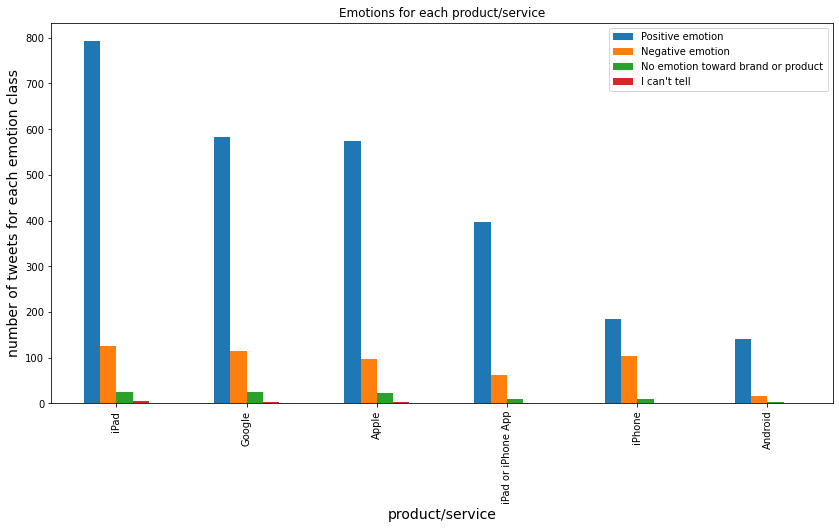

In [19]:
# bar chart listing emotion class for each product_service 

df_pivot.plot(kind='bar',figsize=(14,7));
plt.title('Emotions for each product/service');
plt.ylabel('number of tweets for each emotion class',fontsize=14);
plt.xlabel('product/service',fontsize=14);

We have a clear winner in **_iPad!_** i.e. the iPad is the most popular product among customers and Android the least. We can also that the number of negative tweets seem to be somewhat level across all products except for Android.

# What do customers like about a product_service?

Here, we are looking to answer the second question.We can do this by breaking down each product_service and the different emotions to see if there are any key words that stand out. For eg: we can list out tweets by positive and negative emotions for iPad and analyze separately to gage sentiment.

In [20]:
#updating stopwords list to include SXSW since it appears nearly 10,000 times
stopwords_list.append('SXSW')

Let's define some functions to make things easier:

Function to get only **_positive tweets_**

In [21]:
def get_positive(df,category,emotion):
    positive_df = df.loc[(df['product_service']==category) & (df['emotion']=='Positive emotion')]
    return positive_df        

Function to get only **_negative tweets_**

In [22]:
def get_negative(df,category,emotion):
    negative_df=df.loc[(df['product_service']==category) & (df['emotion']=='Negative emotion')]
    return negative_df
        

Function to generate **_Wordclouds for positive and negative tweets_**

In [23]:
def wordcloud_gen(df,category):
    pos=get_positive(df,category,'Positive emotion')
    neg=get_negative(df,category,'Negative emotion')
    product = category # for use in the heading of the wordcloud

    #instantiate wordclouds
    wc1 = WordCloud(background_color='white',   #positive wc
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )
    wc2 = WordCloud(background_color='black',   #negative wc
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )

#for the wordcloud, we have to join all the text data into a single string 
    text1 = " ".join(pos['tweet_text']) #positive
    text2 = " ".join(neg['tweet_text']) #negative

#generate the WC
    wc1.generate(text1) #positive
    wc2.generate(text2) #negative

#plot the WC
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
    font = {'fontsize':20}
    ax1.imshow(wc1) #positve
    ax1.axis('off')
    ax1.set_title(f'Positive emotions:{product}',fontdict=font);
    ax2.imshow(wc2) #negative
    ax2.axis('off')
    ax2.set_title(f'Negative emotions:{product}',fontdict=font);

## Ipad

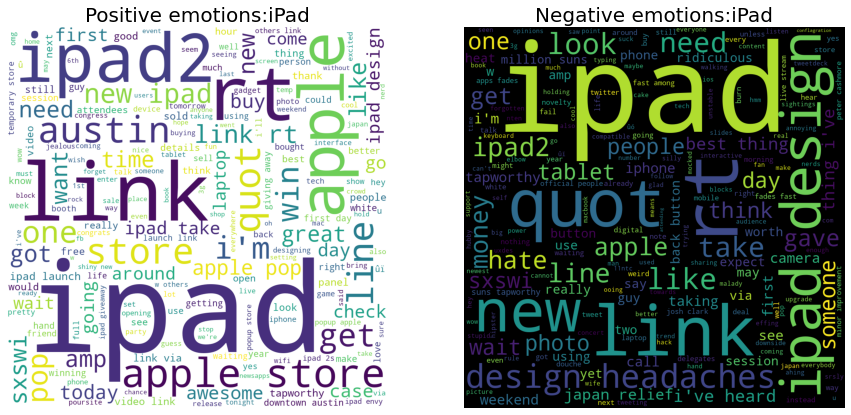

In [24]:
wordcloud_gen(df,'iPad')

From the negative emotions, we can see `design headaches, iPad design,money,back button` are some of the words that feature prominently thus illustrating displeasure of the users regarding some of the features of the `iPad`. `iPad2` is also mentioned quite a lot.

## Apple

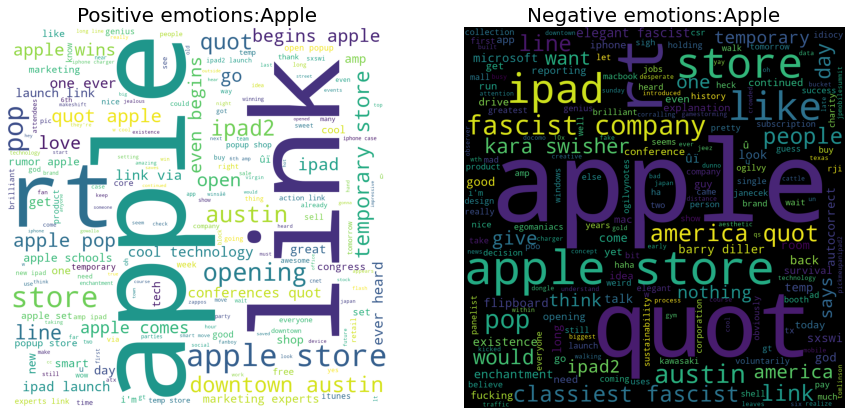

In [25]:
wordcloud_gen(df,'Apple')

Sentiment against Apple seems to be quite severe given the high number of tweets featuring the word `fascist`!

## iPhone

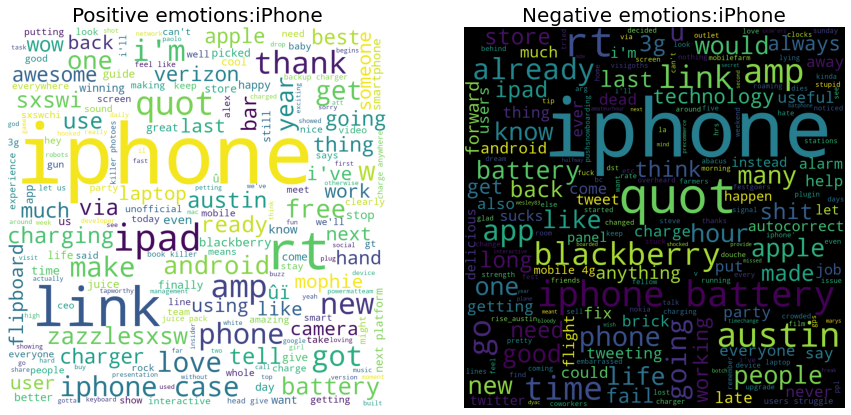

In [26]:
wordcloud_gen(df,'iPhone')

From positive emotions, `verizon` stands out suggesting their superiority from the other carriers. `iphone battery,battery` from the negative emotions illustrate unequivocally where the problem lies with the iPhone.

## Ipad and iPhone apps

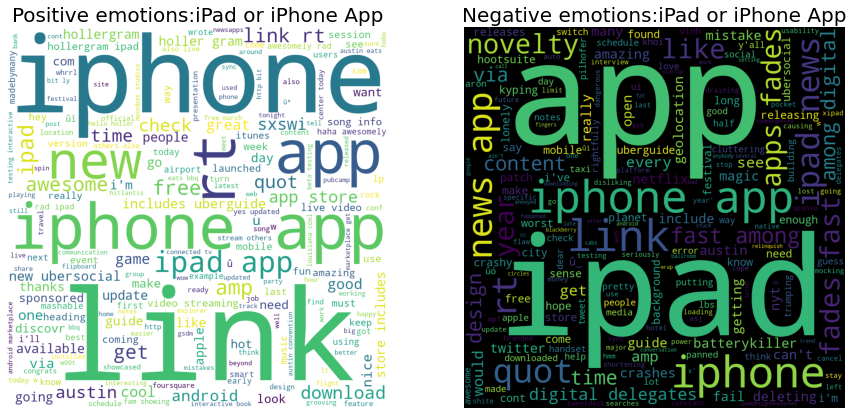

In [27]:
wordcloud_gen(df,'iPad or iPhone App')

Nothing really stands out here

## Google

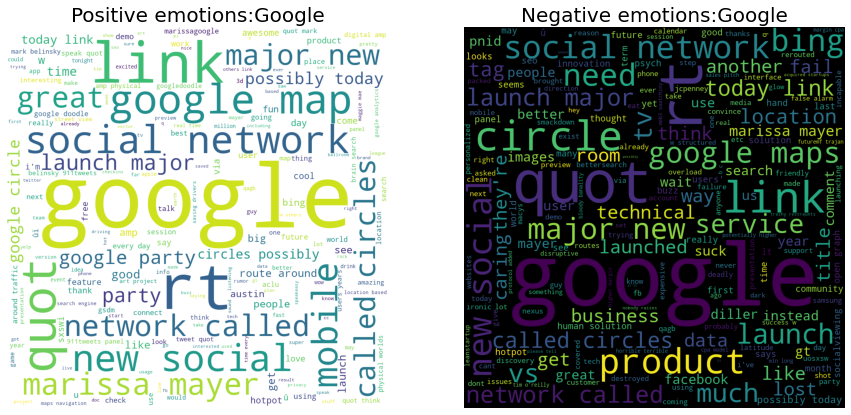

In [28]:
wordcloud_gen(df,'Google')

`google maps` seems to be equally represented in both positive and negative tweets. Some people like it and some don't.
Same thing with `social network`. How that ties in with `google` needs some more exploration.

## Android

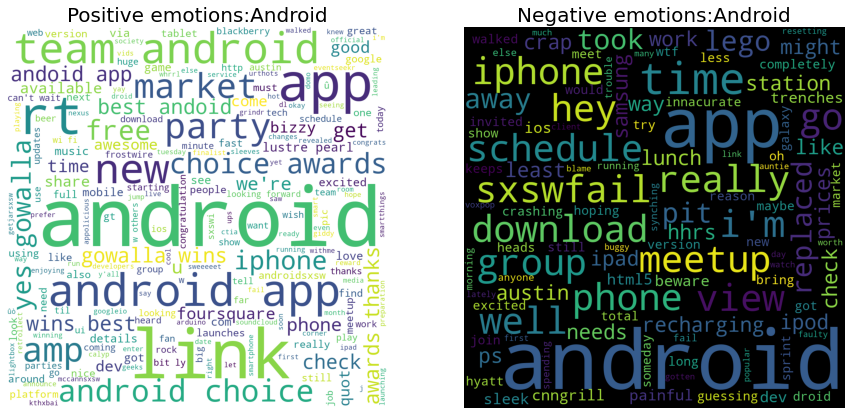

In [29]:
wordcloud_gen(df,'Android')

The words `awards,wins best` from the positve tweets maybe point towards someone from the festival winning or an app on the Android platform winning some award! `Samsung` pops up in negative tweets suggesting issues with apps running on Samsung phones.

# Model to predict company from tweets

Since we're only concerned about which company's is favoured by customers let's futher group the products as Apple and Google.

In [30]:
#let's group product/services that resemble each other for both brands. This will make for easier analysis

df['product_service'].replace('Android','Google',inplace=True)
df['product_service'].replace(['iPhone','iPad','iPad or iPhone App'],'Apple',inplace=True)

#checking 
df['product_service'].value_counts()

Not Applicable    5801
Apple             2409
Google             882
Name: product_service, dtype: int64

In [31]:
# creating target values for product_service
new_map = {'Not Applicable':0,
          'Apple':1,
          'Google':2}

df['target'] = df['product_service'].map(new_map)
df.head()

,tweet_text,product_service,emotion,text_token,target
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...",1
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",1
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph...",1
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2


## Vectorizers

To be able to apply ML models to text data, we must first convert them into a numeric form.

This is accomplished by using _Vectorizers_. _Vectorizers_ convert each word in the corpus into a feature and create vectors for each. There are different vectorizers and here, we will use the following three:

1. CountVectorizer
2. Tf-IDF Vectorizer
3. Word2vec Vectorizer

### CountVectorizer

CountVectorizer builds on the _Bag Of Words_ concept. All the words in the corpus are taken and their frequencies are calculated. The output of the CountVectorizer is a sparse matrix where each feauture is a word and the column is the vector of it's frequencies in each document.

In [32]:
#setting up X,y train and test sets
X= df['text_token']
y = df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

Since we have already pre-processed out text data, we have to circumvent  _CountVectorizer's_ `preprocessing and tokenizing`
parameters. We do this by creating a dummy function:


In [33]:
def dummy(doc):
    return doc

Let's build baseline models using `LogisticRegression,Naive-Bayes,Random Forest and SVM`. We can build pipelines for each model
and calculate the f1-score for each by creating a loop.

In [34]:
# building a pipeline of LogisticRegression, Naive-Bayes, SVM and RandomForest models

pipe_lr = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

pipe_nb = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',MultinomialNB())
                    ])

pipe_rf = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',RandomForestClassifier(random_state=123))
                    ])

pipe_svm = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',svm.SVC(random_state=123))
                    ])

#setting up names for the classification report
names_dict = dict(df['product_service'].value_counts())
names = [name for name in names_dict]

#build a list of tuples to build a df
models=['LogReg', 'MultiNB', 'RForest', 'SVM']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr,pipe_nb,pipe_rf,pipe_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#building a df of the f1_scores
scores = list(zip(models,f1))
scores_df = pd.DataFrame(data=scores,columns=['model','f1_score_cv'])

## Tf-IDF Vectorizer

Tfidf Vectorizer takes into acccount the relative importance of the word to the corpus. It combines _term frequency_ and _inverse_document_frequency_. It calculates how often a word occurs in a document (term frequency) and also how many documents contain the word(inverse document frequency). The output is again a sparse matrix like with CountVectorizer.

In [35]:
# repeating the same processes as above
pipe_lr = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

pipe_nb = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',MultinomialNB())
                    ])

pipe_rf = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',RandomForestClassifier(random_state=123))
                    ])

pipe_svm = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',svm.SVC(random_state=123))
                    ])

#setting up names for the classification report
names_dict = dict(df['product_service'].value_counts())
names = [name for name in names_dict]

#build a list of tuples to build a df
models=['LogReg', 'MultiNB', 'RForest', 'SVM']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr,pipe_nb,pipe_rf,pipe_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#adding the tf f1-scores to the scores_df
scores_df['f1_score_tf'] = f1

Now that we've run models with 2 CV and Tfidf vectorizers, let's visualize the f1-scores of each

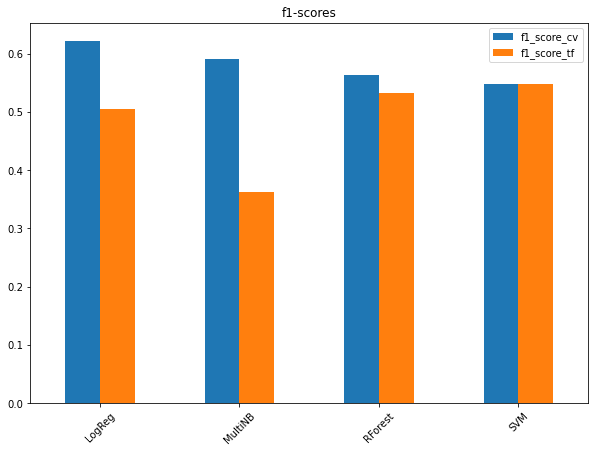

In [36]:
#visualizing the f1-scores of all the models for the two vectorizers

fig,ax = plt.subplots(figsize=(10,7))
scores_df.plot(kind='bar',ax=ax);
ax.set_xticklabels(models,rotation=45);
ax.set_title('f1-scores');


Since the LogisticRegression model with the CountVectorizer has the highest f1-score among all models, let's use that for optimizations

# Tuning LogisticRegression with Countvectorizer

Let's get a closer look at the LR with CV model:

                precision    recall  f1-score   support

Not Applicable       0.75      0.85      0.80      1449
         Apple       0.66      0.54      0.59       593
        Google       0.62      0.39      0.48       231

      accuracy                           0.72      2273
     macro avg       0.68      0.59      0.62      2273
  weighted avg       0.71      0.72      0.71      2273



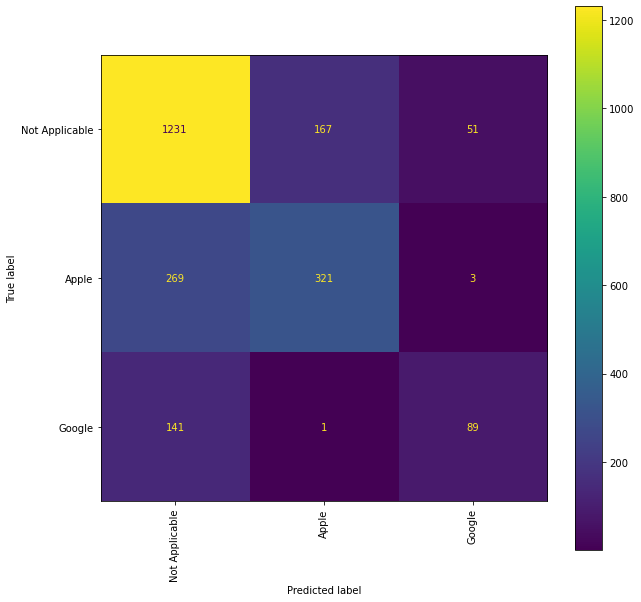

In [37]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

lr_pipe.fit(X_train,y_train)
predictions=lr_pipe.predict(X_test)
print(classification_report(y_test,predictions,target_names=names))
fig,ax=plt.subplots(figsize=(10,10))
plot_confusion_matrix(lr_pipe,X_test,y_test,display_labels=names,ax=ax,xticks_rotation='vertical');

From the above, we can see that the model does relatively well in the `Not Applicable` class compared to `Apple and Google`. This is unsurprising given the imbalance in the data.

## min_df and max_df values

We can try tuning some of the hyperparameters of the model to improve performance. `min_df and max_df` are two that we can look. min_df removes words that appear rarely. Since they are rare, it possible that they
will not provide a lot of information. max_df is the opposite of min_df. If the words are too frequent,
chances are they too do not provide a lot of information.
By creating a range for each parameter, we can run a loop to see if model performance improves

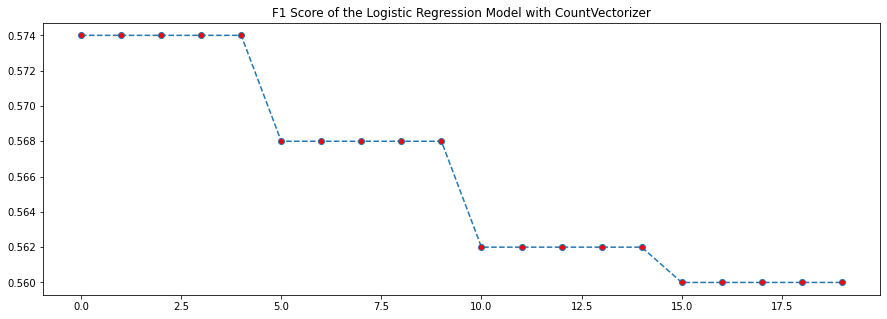

In [38]:
# setting a range for min_df and max_df
min_df_value = np.arange(1,5) # words than appear less than the min_df value in all docs will be eliminated
max_df_value = np.arange(1500,1505) # words than appear more than the max_df value in all docs will be eliminated

#initiating lists to use for plotting
f_score = []
min_value=[]
max_value=[]

#setting up the loop for min_df and max_df values
for i in min_df_value:
    for j in max_df_value:
        min_value.append(i)
        max_value.append(j)
        #instantiate pipeline
        new_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,min_df=i,max_df=j,preprocessor=dummy,tokenizer=dummy)),
                                   ('model',LogisticRegression(random_state=123,solver='liblinear'))
                                   ])
        new_pipe.fit(X_train,y_train)
        preds = new_pipe.predict(X_test)

        #getting f1 score
        score = round(f1_score(y_test,preds,average='macro'),3)
        f_score.append(score)
#         print(f'min_df = {i}, max_df = {j}, f1_score={score}')

#visualizing the accuracy score for the different combinations
d = list(zip(min_value,max_value))
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(f_score,marker='o',markerfacecolor='r',ls='--');
# ax.set_xticklabels(d);
ax.set_title('F1 Score of the Logistic Regression Model with CountVectorizer');

Clearly, we've made the model worse. Our initial f1-score was 0.62 but here we're maxed out at 0.574

## n-gram

The idea behind n-grams is that sometimes word pairings or short phrases are better. For eg: 'black sheep' is more informative than 'black' and 'sheep' seperately

In [39]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy,
                                                  ngram_range=(1,2),min_df=1,max_df=2000)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

lr_pipe.fit(X_train,y_train)
predictions=lr_pipe.predict(X_test)
print(classification_report(y_test,predictions,target_names=names))
# fig,ax=plt.subplots(figsize=(10,10))
# plot_confusion_matrix(lr_pipe,X_test,y_test,display_labels=names,ax=ax,xticks_rotation='vertical');

                precision    recall  f1-score   support

Not Applicable       0.75      0.86      0.80      1449
         Apple       0.67      0.54      0.60       593
        Google       0.63      0.35      0.45       231

      accuracy                           0.73      2273
     macro avg       0.68      0.59      0.62      2273
  weighted avg       0.72      0.73      0.71      2273



We can see that there is no disceernible change in model performance

## Stemming using PorterStemmer

With stemming, we use the use root of the word. For eg: ran,runs,running all stem from the word run. This way we reduce the number of features and can improve accuracy of the model.

In [40]:
#initializing the stemmer
ps=PorterStemmer()

#creating a function to tokenize and stem the tokens
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [ps.stem(token) for token in tokens]

In [41]:
df['stemmed_tokens'] = df['tweet_text'].apply(stem_and_tokenize)
df.head()

,tweet_text,product_service,emotion,text_token,target,stemmed_tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...",1,"[wesley83, have, 3g, iphon, after, hr, tweet, ..."
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1,"[jessede, know, about, fludapp, awesom, ipad, ..."
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",1,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph...",1,"[sxsw, hope, thi, year, festiv, isn, as, crash..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


In [42]:
#running logistic regression on the stemmed tokens
#re-defining X and y
X = df['stemmed_tokens']
y = df['target']

X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,random_state=123)

In [43]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy,
                                                  ngram_range=(1,2),min_df=1,max_df=2000)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

lr_pipe.fit(X_train2,y_train2)
predictions=lr_pipe.predict(X_test2)
print(classification_report(y_test2,predictions,target_names=names))

                precision    recall  f1-score   support

Not Applicable       0.75      0.85      0.80      1449
         Apple       0.66      0.55      0.60       593
        Google       0.61      0.37      0.46       231

      accuracy                           0.72      2273
     macro avg       0.67      0.59      0.62      2273
  weighted avg       0.71      0.72      0.71      2273



# Word2Vec

Word2vec is another vectorization method and falls under the category called **_Word Embeddings_**.  It is essentially a neural network with an i/p layer, hidden layer and an o/p layer.The vectors are created in an **_embedding space_** and are used to capture the semantic relationships between words.

Here, we will import the Word2vec vector from the open source **_gensim_** library and use the **_skip gram_** architecture for modelling. The gensim library has vectors built in that we will use to base our model off of.

In [44]:
#instantiate the vect
model = Word2Vec(df['text_token'], vector_size=100, window=2, min_count=5,sg=1)

#train the model
model.train(df['text_token'],epochs=15,total_examples=model.corpus_count)

(955643, 1574070)

## Experimentation

The calculated vectors are stored in the `Word2VecKeyedVectors` instance stored in the `wv` attribute . Let's assign it to a different variable to save ourselves from lot's of keystrokes

In [45]:
wv=model.wv

Checking the vector for the word `battery`. This will display the weights that the model has calculated for the context that the word 'battery' will most likely used in

In [46]:
wv.most_similar('battery')

[('double', 0.7867036461830139),
 ('brightness', 0.7781798839569092),
 ('realized', 0.761652410030365),
 ('backup', 0.7591707110404968),
 ('charge', 0.751846194267273),
 ('fully', 0.7341135740280151),
 ('size', 0.732403039932251),
 ('extended', 0.7245166897773743),
 ('mine', 0.7168804407119751),
 ('woke', 0.7090649008750916)]

In [47]:
#the vector assocaited with the word 'battery'
wv['battery']

array([-0.458063  , -0.02502533,  0.38549376, -0.33600807,  0.39649984,
       -0.07903578,  0.1819621 ,  0.29431438,  0.20739542,  0.07994445,
       -0.3779416 , -0.45688525, -0.14735016, -0.34771454,  0.30307013,
       -0.5202121 , -0.2096495 , -0.44673064,  0.05725607, -0.53568286,
        0.2255267 ,  0.23559953,  0.3528512 ,  0.21768665,  0.01869281,
        0.3230621 , -0.26309174, -0.02216101, -0.25433   ,  0.1326384 ,
       -0.37892213,  0.39198443, -0.17135786, -0.09877418,  0.24332044,
       -0.17482486, -0.28534567, -0.34956747, -0.27887484, -0.24612875,
       -0.02559326, -0.19868837, -0.06828183, -0.05406783,  0.49589828,
       -0.37562948, -0.20412196,  0.3731071 , -0.25972912,  0.73693126,
        0.06683654, -0.2371239 ,  0.08141746,  0.18420456, -0.51862   ,
       -0.02515164, -0.5578034 ,  0.03833786,  0.04436965, -0.11567891,
       -0.12461101, -0.03954846,  0.02147512, -0.1074824 , -0.504876  ,
        0.05583837, -0.31299314,  0.3331993 , -0.47543064,  0.36

In [48]:
#getting the list of words from the model
words = list(model.wv.index_to_key)
words[0:10] #looking at the first 10 words

['sxsw',
 'link',
 'rt',
 'google',
 'ipad',
 'apple',
 'quot',
 'iphone',
 'store',
 'new']

In [49]:
#getting the vectors assocated with each of those words
vector_list = [model.wv[word] for word in words]
vector_list[0] #examining the vector for the first word

array([ 0.16129974,  0.44971538,  0.14652793,  0.16400129,  0.241857  ,
       -0.48492217, -0.24386829,  0.32161146, -0.78222835, -0.2512979 ,
        0.0288084 , -0.25502527,  0.34294298,  0.10047172, -0.20630549,
       -0.28241104,  0.04872093,  0.28634363, -0.2926324 , -0.6236666 ,
        0.54523987,  0.5269636 ,  0.42986992, -0.3441956 ,  0.23233561,
        0.21865852, -0.06133909,  0.02114165, -0.17238948, -0.07506595,
       -0.02888482, -0.07903518,  0.45007268, -0.23710124,  0.32290313,
       -0.2836894 ,  0.3768982 , -0.16609818,  0.06187427, -0.35884878,
       -0.23399194,  0.17447264, -0.200445  ,  0.23324059, -0.00280966,
       -0.03941862, -0.27208516,  0.49460414,  0.03271766,  0.4440001 ,
       -0.17890699,  0.22153538, -0.23021622,  0.08251876,  0.43140376,
        0.41762897,  0.07753845, -0.3888811 , -0.305017  , -0.17112143,
       -0.48299247, -0.17305574, -0.06959482, -0.21845378,  0.08606995,
        0.2737974 , -0.0480854 ,  0.23368078,  0.1523709 ,  0.04

In [50]:
#creating a df
word_vect_zip = dict(zip(words,vector_list))
word_vect_df = pd.DataFrame(word_vect_zip)
word_vect_df.head()

,sxsw,link,rt,google,ipad,apple,quot,iphone,store,new,...,record,presentations,diff,teo,copyright,akqa,produced,mtg,wine,optimistic
0,0.161300,-0.140039,-0.157221,0.074618,-0.694926,-0.088081,0.154747,0.376678,-0.236402,-0.248986,...,-0.190896,-0.033717,-0.147130,-0.371712,-0.150371,-0.333597,-0.130107,-0.328287,-0.150542,-0.186417
1,0.449715,0.483162,0.394712,0.872012,-0.271413,0.146678,0.345933,0.170995,0.253741,0.575488,...,0.154698,0.028256,0.217884,0.291615,0.068600,0.253931,0.218124,0.150745,0.189965,0.110389
2,0.146528,0.349560,-0.003395,-0.029966,0.519249,0.138923,0.241712,0.825991,0.061831,0.032885,...,0.012908,0.130653,0.056092,0.172278,0.045663,0.091097,0.080132,0.221810,0.112424,0.116720
3,0.164001,-0.123589,0.328294,-0.189754,0.070910,-0.172045,-0.265406,0.069125,0.457136,0.022353,...,0.111363,-0.144814,0.013545,0.175779,-0.025958,0.127927,-0.247121,0.130669,-0.086853,-0.003586
4,0.241857,0.115546,0.603267,0.403906,0.806486,-0.145938,0.441866,0.228265,0.555975,0.612091,...,0.094535,-0.012961,0.100039,0.209816,-0.134798,0.093732,0.135819,-0.181042,0.004791,0.123566


The df is used to illustrate the different words created by the model and their corresponding vectors.

## Mean Embeddings

Now, we need to get a vector representation for each document to be able to apply a ML model. For this, we will take the mean of the vectors in each document for the words that are in the model vocabulary. Let's define a function to get the mean vector for each document:

In [51]:
#to get the vector representation of each document, you will define a fuction that will create a 
#vector for each word in the document that is in the model's vocab,beacuse obviously you cannot have
#vectors for words that are not there. Then you will take the average of the vectors and the resultant 
#vector will the vector for that document

def doc_vector(token):
    vector_size=model.wv.vector_size #getting the size of the vectors created 
    resultant_vector = np.zeros(vector_size) # initializing a vector of zeros of the same size
    ctr=1 #counter
    for w in token:
        if w in words:
            ctr += 1
            resultant_vector += wv[w]
    resultant_vector = resultant_vector/ctr
    return resultant_vector

In [52]:
#applying the function to the stemmed_tokens colums
df['vectors'] = df['stemmed_tokens'].apply(doc_vector)
df.head()

,tweet_text,product_service,emotion,text_token,target,stemmed_tokens,vectors
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...",1,"[wesley83, have, 3g, iphon, after, hr, tweet, ...","[-0.15938760712742805, 0.16340333516044275, 0...."
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1,"[jessede, know, about, fludapp, awesom, ipad, ...","[-0.30995416454970837, -0.0574743299279362, 0...."
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",1,"[swonderlin, can, not, wait, for, ipad, also, ...","[-0.2591584026813507, 0.0773914522336175, 0.26..."
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph...",1,"[sxsw, hope, thi, year, festiv, isn, as, crash...","[-0.08945630863308907, 0.25930281409195494, 0...."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[-0.2125457836581128, 0.020851770681994303, -0..."


## Modelling

Now that we have a vecotrized representation of each document, we can apply different ML models and check performance

In [53]:
#redefining X&y
X= df['vectors'].to_list()
y = df['target'].to_list()

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

In [54]:
# repeating the same processes as above
pipe_lr_wv = Pipeline([('model',LogisticRegression(random_state=123,solver='liblinear'))])

# pipe_nb_wv = Pipeline([('model',MultinomialNB())])
#cannot use NB on negative values. Values will have to be normalized instead

pipe_rf_wv = Pipeline([('model',RandomForestClassifier(random_state=123))])

pipe_svm_wv = Pipeline([('model',svm.SVC(random_state=123))])

#build a list of tuples to build a df
models=['LogReg_wv', 'RForest_wv', 'SVM_wv']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr_wv,pipe_rf_wv,pipe_svm_wv]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#building a df of the f1_scores
scores_wv = list(zip(models,f1))
scores_df_wv = pd.DataFrame(data=scores_wv,columns=['model','f1_score_wv'])

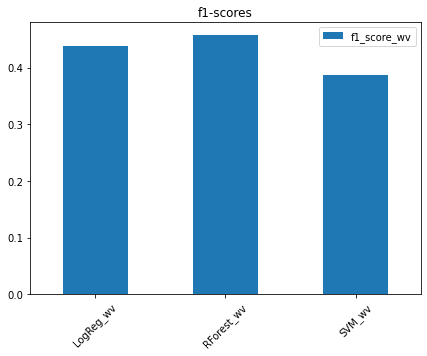

In [55]:
fig,ax = plt.subplots(figsize=(7,5))
scores_df_wv.plot(kind='bar',ax=ax);
ax.set_xticklabels(models,rotation=45);
ax.set_title('f1-scores');

As we can see, with Word2vec, the max f1-score that we can achieve is only 0.45, much less than our highest score of 0.62

# Next Steps

1. More data is definitely recommended. Current data is very imbalanced impacting model performance.
2. The hyperparameters of the Word2Vec vectorizer i.e number of epochs, size of the vectors etc. can be tuned to see if results improve.
3. Part-of-Speech tagging can be used to create more features.
4. Ensemble methods like XGBoost and Adaboost can also be trialled for modelling along with other word embedding techniques like fastText and Glove.
